# Experiment: Hierarchical Agglomerative Clustering

Task: **clustering**

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)

REPO_ROOT = Path.cwd().resolve().parents[0]  # notebooks/ -> repo root
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_csv = DATASET_DIR / 'split.csv'

print(f'Using prepared dataset: {DATASET_DIR}')
print(f'Using baseline config:  {BASELINE_CONFIG_JSON}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

splits = pd.read_csv(split_csv)

from src.pipelines.features import apply_baseline_feature_config, load_baseline_feature_config
cfg = load_baseline_feature_config(BASELINE_CONFIG_JSON)

required_cols = {cfg.row_id_col, cfg.target_col}
missing_required = required_cols - set(df.columns)
if missing_required:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing_required)}')

X_full = apply_baseline_feature_config(df, cfg)
y_full = df[cfg.target_col].astype(str)

df_split = df[[cfg.row_id_col]].merge(splits[[cfg.row_id_col, 'split']], on=cfg.row_id_col, how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (split.csv join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

X_train, y_train = X_full.loc[mask_train].reset_index(drop=True), y_full.loc[mask_train].reset_index(drop=True)
X_val, y_val = X_full.loc[mask_val].reset_index(drop=True), y_full.loc[mask_val].reset_index(drop=True)
X_test, y_test = X_full.loc[mask_test].reset_index(drop=True), y_full.loc[mask_test].reset_index(drop=True)

print('Split sizes:', X_train.shape, X_val.shape, X_test.shape)


Using prepared dataset: C:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29
Using baseline config:  C:\repos\ml-cybersecurity_attacks\config\baseline_feature_config.json
Split sizes: (28000, 25) (6000, 25) (6000, 25)


In [2]:
# Build preprocessing: impute + one-hot for categoricals; impute (+ optional scale) for numeric

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('string')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
]
num_steps = [s for s in num_steps if not (isinstance(s, str) or s[0].startswith('#'))]
num_pipe = Pipeline(steps=num_steps)

preprocess = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
    remainder='drop',
)

print(f'Categorical cols: {len(cat_cols)}')
print(f'Numeric cols:     {len(num_cols)}')


Categorical cols: 11
Numeric cols:     14


In [3]:
# Model definition + clustering

from sklearn.cluster import AgglomerativeClustering

n_clusters = int(y_train.nunique())
model = AgglomerativeClustering(n_clusters=n_clusters)

# For clustering, fit on train only (no leakage), then evaluate cluster quality vs labels.
X_train_t = preprocess.fit_transform(X_train)
train_labels = model.fit_predict(X_train_t)


In [4]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def eval_clusters(name: str, y_true, labels) -> None:
    print(f'\n== {name} ==')
    print('ARI:', adjusted_rand_score(y_true, labels))
    print('NMI:', normalized_mutual_info_score(y_true, labels))

eval_clusters('train', y_train, train_labels)



== train ==
ARI: 2.6422634350015596e-05
NMI: 7.662019815236926e-05


## Charts

All plots below use the shared `color_palette` from `config/visualization.json` for consistent styling across experiments.

In [5]:
import json
from collections import Counter

import matplotlib.pyplot as plt


def load_color_palette() -> list[str]:
    viz_path = REPO_ROOT / "config" / "visualization.json"
    with viz_path.open("r", encoding="utf-8") as f:
        viz = json.load(f)

    palette = viz.get("visualization", {}).get("color_palette")
    if not palette:
        raise KeyError(f"Missing visualization.color_palette in {viz_path}")
    if not isinstance(palette, list) or not all(isinstance(c, str) for c in palette):
        raise TypeError("visualization.color_palette must be a list[str]")

    return palette


color_palette = load_color_palette()
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_palette)

print(f"Loaded color_palette ({len(color_palette)} colors) from config/visualization.json")

Loaded color_palette (9 colors) from config/visualization.json


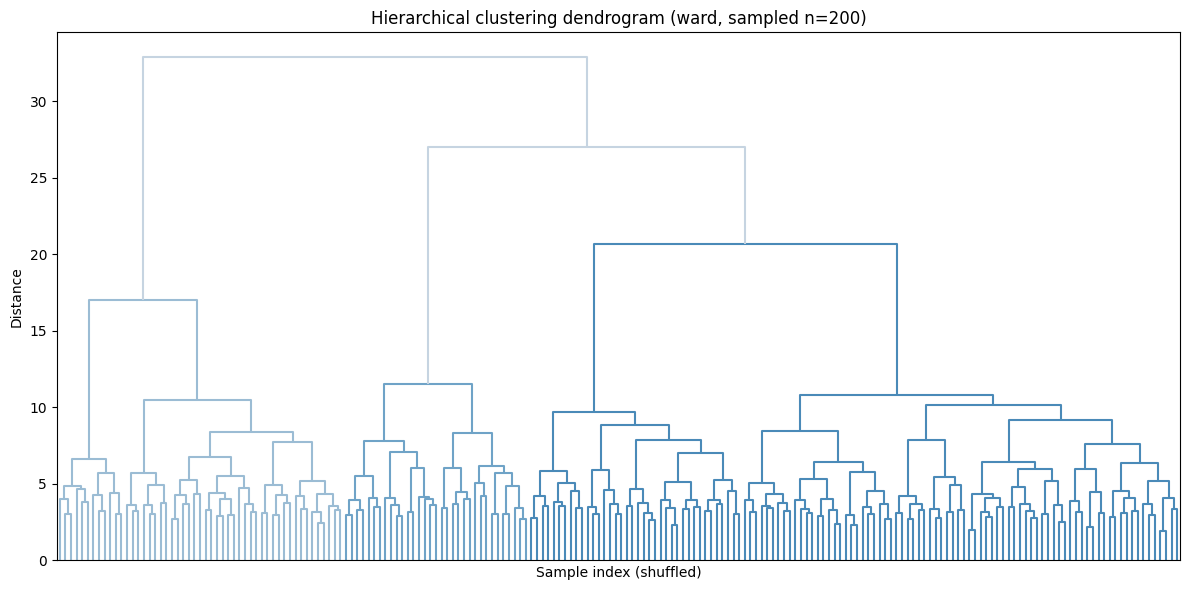

Dendrogram built from sampled rows: n=200


In [6]:
# 1) Dendrogram (sampled)
# Agglomerative dendrograms can be expensive; we sample for readability/performance.

from scipy.cluster.hierarchy import dendrogram, linkage

sample_size = min(200, X_train_t.shape[0])
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(X_train_t.shape[0], size=sample_size, replace=False)

Z = linkage(X_train_t[sample_idx], method="ward", metric="euclidean")

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    no_labels=True,
    color_threshold=None,
    above_threshold_color=color_palette[0],
)
plt.title(f"Hierarchical clustering dendrogram (ward, sampled n={sample_size})")
plt.xlabel("Sample index (shuffled)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

print(f"Dendrogram built from sampled rows: n={sample_size}")

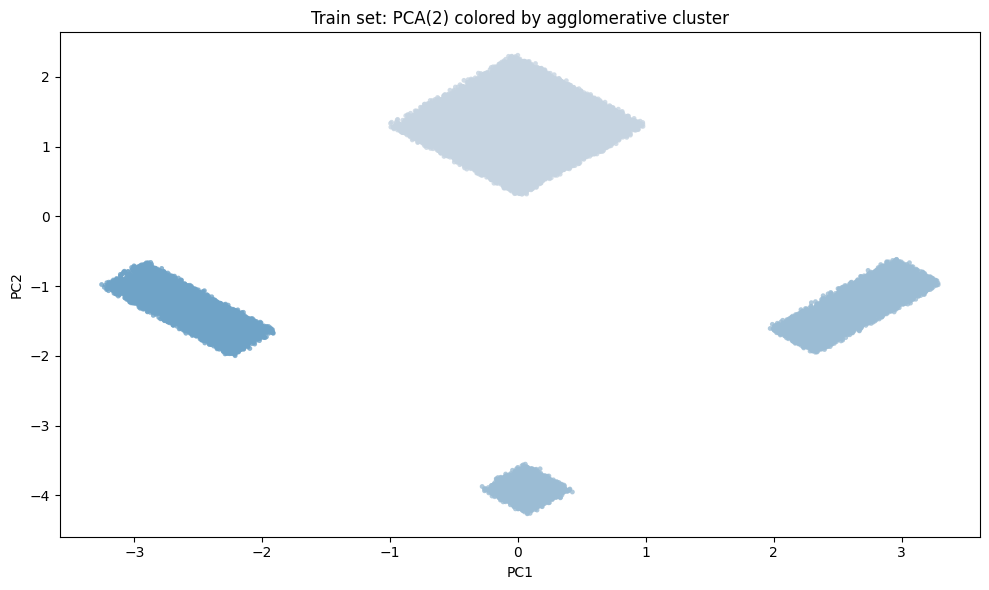

PCA explained variance ratio: [0.15999878 0.1580125 ]


In [7]:
# 2) 2D view of clusters (PCA)

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=SEED)
X2 = pca.fit_transform(X_train_t)

# Map each cluster id -> palette color (cycles if clusters > palette length)
cluster_ids = np.asarray(train_labels)
unique_clusters = np.unique(cluster_ids)
cluster_to_color = {int(cid): color_palette[i % len(color_palette)] for i, cid in enumerate(unique_clusters)}
point_colors = [cluster_to_color[int(cid)] for cid in cluster_ids]

plt.figure(figsize=(10, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=point_colors, s=12, alpha=0.8, linewidths=0)
plt.title("Train set: PCA(2) colored by agglomerative cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

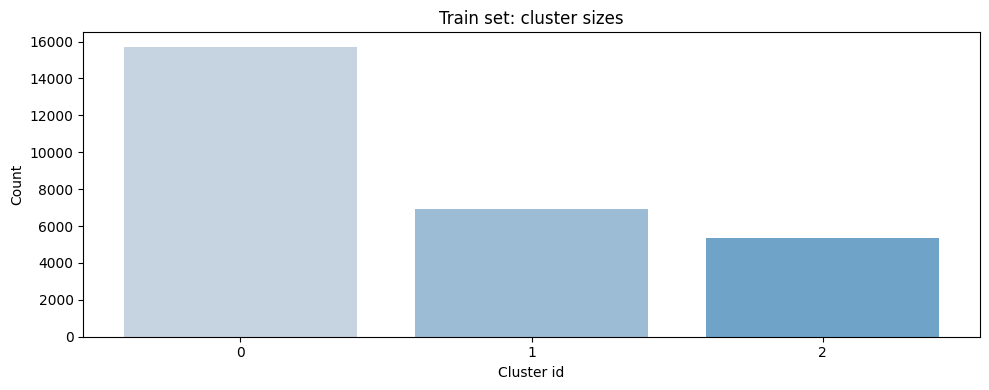

Cluster sizes:
  cluster 0: 15714
  cluster 1: 6925
  cluster 2: 5361


In [8]:
# 3) Cluster size distribution

counts = Counter(map(int, train_labels))
ordered = sorted(counts.items(), key=lambda kv: kv[0])
cluster_x = [c for c, _ in ordered]
cluster_n = [n for _, n in ordered]
bar_colors = [cluster_to_color[int(c)] for c in cluster_x]

plt.figure(figsize=(10, 4))
plt.bar(cluster_x, cluster_n, color=bar_colors)
plt.title("Train set: cluster sizes")
plt.xlabel("Cluster id")
plt.ylabel("Count")
plt.xticks(cluster_x)
plt.tight_layout()
plt.show()

print("Cluster sizes:")
for c, n in ordered:
    print(f"  cluster {c}: {n}")